In [149]:
from pathlib import Path
from freqtrade.configuration import Configuration

import pandas as pd
import numpy as np
import statistics
import math
# Customize these according to your needs.s

# Initialize empty configuration object
path='F:\\Projects\\freqtrade\\user_data\\configs\\'

config = Configuration.from_files([path + "config_binance_zone1.json"])

# Optionally, use existing configuration file
# config = Configuration.from_files(["config.json"])

# Define some constants
config["timeframe"] = "4h"
# Name of the strategy class
config["strategy"] = "YoyoActionStrategy"
# Location of the data
data_location = Path(config['user_data_dir'], 'data', 'binance')
# Pair to analyze - Only use one pair here
pair = "BTC/USDT"
# F:\\Projects\\freqtrade\\user_data
# if backtest_dir points to a directory, it'll automatically load the last backtest file.
backtest_dir = config["user_data_dir"] / "backtest_results/backtest-result-2021-05-26_11-44-26.json"

In [150]:
from freqtrade.data.history import load_pair_history

candles = load_pair_history(datadir=data_location,
                            timeframe=config["timeframe"],
                            pair=pair)

# Confirm success
print("Loaded " + str(len(candles)) + f" rows of data for {pair} from {data_location}")
candles.head()

Loaded 8040 rows of data for BTC/USDT from F:\Projects\freqtrade\user_data\data\binance


,date,open,high,low,close,volume
0,2017-08-17 04:00:00+00:00,4261.48,4349.99,4261.32,4349.99,82.088865
1,2017-08-17 08:00:00+00:00,4333.32,4485.39,4333.32,4427.30,63.619882
2,2017-08-17 12:00:00+00:00,4436.06,4485.39,4333.42,4352.34,174.562001
3,2017-08-17 16:00:00+00:00,4352.33,4354.84,4200.74,4325.23,225.109716
4,2017-08-17 20:00:00+00:00,4307.56,4369.69,4258.56,4285.08,249.769913


In [151]:
# Load strategy using values set above
from freqtrade.resolvers import StrategyResolver
strategy = StrategyResolver.load_strategy(config)

# Generate buy/sell signals using strategy 
df = strategy.analyze_ticker(candles, {'pair': pair})
df.tail()

C:\Users\Freshconsulting\Anaconda3\envs\tensorflow_freqtrade\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,date,open,high,low,close,volume,ohlc4,ema_fast,ema_slow,rsi,...,greenLine,greenLine_last,short_last,green_last,red_last,hold_state,signal_buy,signal_sell,buy,sell
8035,2021-04-17 08:00:00+00:00,62114.99,62458.28,60700.55,60886.91,11323.908231,61540.1825,61925.59179185,59678.91240538,43.52519143,...,False,False,False,True,False,False,NaN,NaN,NaN,NaN
8036,2021-04-17 12:00:00+00:00,60886.93,61222.00,60094.00,60264.66,13371.078768,60616.8975,61792.71724850,59689.27961945,40.20974269,...,False,False,False,False,False,False,NaN,NaN,NaN,NaN
8037,2021-04-17 16:00:00+00:00,60264.65,60785.00,59580.91,60705.02,10217.080882,60333.8950,61705.70146862,59707.25732530,43.49033314,...,False,False,False,False,False,False,NaN,NaN,NaN,NaN
8038,2021-04-17 20:00:00+00:00,60705.02,60955.00,59969.98,60006.66,5977.350070,60409.1650,61569.77815113,59712.55648768,39.76410860,...,False,False,False,False,False,False,NaN,NaN,NaN,NaN
8039,2021-04-18 00:00:00+00:00,60006.67,60499.00,50931.30,55014.46,28130.890376,56612.8575,61045.35269904,59629.40433746,23.96021053,...,False,False,False,False,False,False,NaN,NaN,NaN,NaN


In [152]:
print(f"Generated {df['buy'].sum()} buy signals")
data = df.set_index('date', drop=False)
data.tail()

Generated 1191.0 buy signals


,date,open,high,low,close,volume,ohlc4,ema_fast,ema_slow,rsi,...,greenLine,greenLine_last,short_last,green_last,red_last,hold_state,signal_buy,signal_sell,buy,sell
date,,,,,,,,,,,,,,,,,,,,,
2021-04-17 08:00:00+00:00,2021-04-17 08:00:00+00:00,62114.99,62458.28,60700.55,60886.91,11323.908231,61540.1825,61925.59179185,59678.91240538,43.52519143,...,False,False,False,True,False,False,NaN,NaN,NaN,NaN
2021-04-17 12:00:00+00:00,2021-04-17 12:00:00+00:00,60886.93,61222.00,60094.00,60264.66,13371.078768,60616.8975,61792.71724850,59689.27961945,40.20974269,...,False,False,False,False,False,False,NaN,NaN,NaN,NaN
2021-04-17 16:00:00+00:00,2021-04-17 16:00:00+00:00,60264.65,60785.00,59580.91,60705.02,10217.080882,60333.8950,61705.70146862,59707.25732530,43.49033314,...,False,False,False,False,False,False,NaN,NaN,NaN,NaN
2021-04-17 20:00:00+00:00,2021-04-17 20:00:00+00:00,60705.02,60955.00,59969.98,60006.66,5977.350070,60409.1650,61569.77815113,59712.55648768,39.76410860,...,False,False,False,False,False,False,NaN,NaN,NaN,NaN
2021-04-18 00:00:00+00:00,2021-04-18 00:00:00+00:00,60006.67,60499.00,50931.30,55014.46,28130.890376,56612.8575,61045.35269904,59629.40433746,23.96021053,...,False,False,False,False,False,False,NaN,NaN,NaN,NaN


In [153]:
from freqtrade.data.btanalysis import load_backtest_data, load_backtest_stats


In [154]:
backtest_dir

WindowsPath('F:/Projects/freqtrade/user_data/backtest_results/backtest-result-2021-05-26_11-44-26.json')

In [155]:
stats = load_backtest_stats(backtest_dir)

strategy = config["strategy"]
# All statistics are available per strategy, so if `--strategy-list` was used during backtest, this will be reflected here as well.
# Example usages:
print(stats['strategy'][strategy]['results_per_pair'])
# Get pairlist used for this backtest
print(stats['strategy'][strategy]['pairlist'])
# Get market change (average change of all pairs from start to end of the backtest period)
print(stats['strategy'][strategy]['market_change'])
# Maximum drawdown ()
print(stats['strategy'][strategy]['max_drawdown'])
# Maximum drawdown start and end
print(stats['strategy'][strategy]['drawdown_start'])
print(stats['strategy'][strategy]['drawdown_end'])

# Get strategy comparison (only relevant if multiple strategies were compared)
print(stats['strategy_comparison'])

[{'key': 'BNB/USDT', 'trades': 113, 'profit_mean': 0.2015597943362832, 'profit_mean_pct': 20.15597943362832, 'profit_sum': 22.77625676, 'profit_sum_pct': 2277.63, 'profit_total_abs': 11399.51650961, 'profit_total': 1.1399516509610002, 'profit_total_pct': 114.0, 'duration_avg': '7 days, 17:48:00', 'wins': 22, 'draws': 0, 'losses': 91}, {'key': 'LINK/USDT', 'trades': 64, 'profit_mean': 0.12247726421875, 'profit_mean_pct': 12.247726421875, 'profit_sum': 7.83854491, 'profit_sum_pct': 783.85, 'profit_total_abs': 3923.19169934, 'profit_total': 0.392319169934, 'profit_total_pct': 39.23, 'duration_avg': '9 days, 0:26:00', 'wins': 18, 'draws': 0, 'losses': 46}, {'key': 'RUNE/USDT', 'trades': 13, 'profit_mean': 0.5321168376923077, 'profit_mean_pct': 53.21168376923077, 'profit_sum': 6.91751889, 'profit_sum_pct': 691.75, 'profit_total_abs': 3462.2182043499997, 'profit_total': 0.346221820435, 'profit_total_pct': 34.62, 'duration_avg': '13 days, 9:32:00', 'wins': 6, 'draws': 0, 'losses': 7}, {'key':

In [156]:
strategy_comparison = stats['strategy_comparison']
# strategy_comparison.loc[(strategy_comparison['key'] == 'YoyoActionStrategy')]
#strategy_comparison[[0]['key']
stats['strategy']['YoyoActionStrategy'].keys()

dict_keys(['trades', 'locks', 'best_pair', 'worst_pair', 'results_per_pair', 'sell_reason_summary', 'left_open_trades', 'total_trades', 'total_volume', 'avg_stake_amount', 'profit_mean', 'profit_median', 'profit_total', 'profit_total_abs', 'backtest_start', 'backtest_start_ts', 'backtest_end', 'backtest_end_ts', 'backtest_days', 'backtest_run_start_ts', 'backtest_run_end_ts', 'trades_per_day', 'market_change', 'pairlist', 'stake_amount', 'stake_currency', 'stake_currency_decimals', 'starting_balance', 'dry_run_wallet', 'final_balance', 'max_open_trades', 'max_open_trades_setting', 'timeframe', 'timerange', 'enable_protections', 'strategy_name', 'stoploss', 'trailing_stop', 'trailing_stop_positive', 'trailing_stop_positive_offset', 'trailing_only_offset_is_reached', 'use_custom_stoploss', 'minimal_roi', 'use_sell_signal', 'sell_profit_only', 'sell_profit_offset', 'ignore_roi_if_buy_signal', 'backtest_best_day', 'backtest_worst_day', 'backtest_best_day_abs', 'backtest_worst_day_abs', 'wi

In [157]:
stats['strategy']['YoyoActionStrategy']['trades']

2021-02-24 08:00:00+00:00',
  'close_date': '2021-02-28 12:00:00+00:00',
  'open_rate': 253.8284,
  'close_rate': 203.06272,
  'fee_open': 0.001,
  'fee_close': 0.001,
  'trade_duration': 6000,
  'profit_ratio': -0.2015984,
  'profit_abs': -100.90000006,
  'sell_reason': 'stop_loss',
  'initial_stop_loss_abs': 203.06272,
  'initial_stop_loss_ratio': -0.2,
  'stop_loss_abs': 203.06272,
  'stop_loss_ratio': -0.2,
  'min_rate': 216.3855,
  'max_rate': 281.0,
  'is_open': False,
  'open_timestamp': 1614153600000.0,
  'close_timestamp': 1614513600000.0},
 {'pair': 'ETH/USDT',
  'stake_amount': 500,
  'amount': 0.3278796,
  'open_date': '2021-03-01 12:00:00+00:00',
  'close_date': '2021-03-03 00:00:00+00:00',
  'open_rate': 1524.95,
  'close_rate': 1486.79,
  'fee_open': 0.001,
  'fee_close': 0.001,
  'trade_duration': 2160,
  'profit_ratio': -0.02697178,
  'profit_abs': -13.49937364,
  'sell_reason': 'sell_signal',
  'initial_stop_loss_abs': 1219.96,
  'initial_stop_loss_ratio': -0.2,
  'st

In [158]:
# Load data using values set above
from freqtrade.data.history import load_pair_history

candles = load_pair_history(datadir=data_location,
                            timeframe=config["timeframe"],
                            pair=pair)

# Confirm success
print("Loaded " + str(len(candles)) + f" rows of data for {pair} from {data_location}")
candles.head()

Loaded 8040 rows of data for BTC/USDT from F:\Projects\freqtrade\user_data\data\binance


,date,open,high,low,close,volume
0,2017-08-17 04:00:00+00:00,4261.48,4349.99,4261.32,4349.99,82.088865
1,2017-08-17 08:00:00+00:00,4333.32,4485.39,4333.32,4427.30,63.619882
2,2017-08-17 12:00:00+00:00,4436.06,4485.39,4333.42,4352.34,174.562001
3,2017-08-17 16:00:00+00:00,4352.33,4354.84,4200.74,4325.23,225.109716
4,2017-08-17 20:00:00+00:00,4307.56,4369.69,4258.56,4285.08,249.769913


In [159]:
# Load strategy using values set above
from freqtrade.resolvers import StrategyResolver
strategy = StrategyResolver.load_strategy(config)

# Generate buy/sell signals using strategy
df = strategy.analyze_ticker(candles, {'pair': pair})
df.tail()

C:\Users\Freshconsulting\Anaconda3\envs\tensorflow_freqtrade\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,date,open,high,low,close,volume,ohlc4,ema_fast,ema_slow,rsi,...,greenLine,greenLine_last,short_last,green_last,red_last,hold_state,signal_buy,signal_sell,buy,sell
8035,2021-04-17 08:00:00+00:00,62114.99,62458.28,60700.55,60886.91,11323.908231,61540.1825,61925.59179185,59678.91240538,43.52519143,...,False,False,False,True,False,False,NaN,NaN,NaN,NaN
8036,2021-04-17 12:00:00+00:00,60886.93,61222.00,60094.00,60264.66,13371.078768,60616.8975,61792.71724850,59689.27961945,40.20974269,...,False,False,False,False,False,False,NaN,NaN,NaN,NaN
8037,2021-04-17 16:00:00+00:00,60264.65,60785.00,59580.91,60705.02,10217.080882,60333.8950,61705.70146862,59707.25732530,43.49033314,...,False,False,False,False,False,False,NaN,NaN,NaN,NaN
8038,2021-04-17 20:00:00+00:00,60705.02,60955.00,59969.98,60006.66,5977.350070,60409.1650,61569.77815113,59712.55648768,39.76410860,...,False,False,False,False,False,False,NaN,NaN,NaN,NaN
8039,2021-04-18 00:00:00+00:00,60006.67,60499.00,50931.30,55014.46,28130.890376,56612.8575,61045.35269904,59629.40433746,23.96021053,...,False,False,False,False,False,False,NaN,NaN,NaN,NaN


In [160]:
# Report results
print(f"Generated {df['buy'].sum()} buy signals")
data = df.set_index('date', drop=False)
data.tail()

Generated 1191.0 buy signals


,date,open,high,low,close,volume,ohlc4,ema_fast,ema_slow,rsi,...,greenLine,greenLine_last,short_last,green_last,red_last,hold_state,signal_buy,signal_sell,buy,sell
date,,,,,,,,,,,,,,,,,,,,,
2021-04-17 08:00:00+00:00,2021-04-17 08:00:00+00:00,62114.99,62458.28,60700.55,60886.91,11323.908231,61540.1825,61925.59179185,59678.91240538,43.52519143,...,False,False,False,True,False,False,NaN,NaN,NaN,NaN
2021-04-17 12:00:00+00:00,2021-04-17 12:00:00+00:00,60886.93,61222.00,60094.00,60264.66,13371.078768,60616.8975,61792.71724850,59689.27961945,40.20974269,...,False,False,False,False,False,False,NaN,NaN,NaN,NaN
2021-04-17 16:00:00+00:00,2021-04-17 16:00:00+00:00,60264.65,60785.00,59580.91,60705.02,10217.080882,60333.8950,61705.70146862,59707.25732530,43.49033314,...,False,False,False,False,False,False,NaN,NaN,NaN,NaN
2021-04-17 20:00:00+00:00,2021-04-17 20:00:00+00:00,60705.02,60955.00,59969.98,60006.66,5977.350070,60409.1650,61569.77815113,59712.55648768,39.76410860,...,False,False,False,False,False,False,NaN,NaN,NaN,NaN
2021-04-18 00:00:00+00:00,2021-04-18 00:00:00+00:00,60006.67,60499.00,50931.30,55014.46,28130.890376,56612.8575,61045.35269904,59629.40433746,23.96021053,...,False,False,False,False,False,False,NaN,NaN,NaN,NaN


In [161]:
trades = load_backtest_data(backtest_dir)

# Show value-counts per pair
trades.groupby("pair")["sell_reason"].value_counts()

pair       sell_reason
BNB/USDT   sell_signal    107
           stop_loss        3
           roi              2
           force_sell       1
BTC/USDT   sell_signal    129
           force_sell       1
BTT/USDT   sell_signal     84
           force_sell       1
DOT/USDT   sell_signal     13
           stop_loss        1
ETH/USDT   sell_signal    129
           force_sell       1
IOST/USDT  sell_signal     79
           stop_loss        3
           force_sell       1
KNC/USDT   sell_signal     25
           force_sell       1
           stop_loss        1
LINK/USDT  sell_signal     63
           force_sell       1
NEAR/USDT  sell_signal      8
OMG/USDT   sell_signal     79
REEF/USDT  sell_signal      2
RSR/USDT   sell_signal     18
           stop_loss        1
RUNE/USDT  sell_signal     12
           force_sell       1
Name: sell_reason, dtype: int64

In [162]:
trades

,pair,stake_amount,amount,open_date,close_date,open_rate,close_rate,fee_open,fee_close,trade_duration,...,sell_reason,initial_stop_loss_abs,initial_stop_loss_ratio,stop_loss_abs,stop_loss_ratio,min_rate,max_rate,is_open,open_timestamp,close_timestamp
0,BTC/USDT,500,0.11450845,2017-09-06 00:00:00+00:00,2017-09-10 08:00:00+00:00,4366.490000,3988.89000,0.001,0.001,6240,...,sell_signal,3493.1920000,-0.2,3493.1920000,-0.2,4100.000000,4788.590000,False,1.50465600e+12,1.50503040e+12
1,ETH/USDT,500,1.53586239,2017-09-06 04:00:00+00:00,2017-09-08 16:00:00+00:00,325.550000,294.06000,0.001,0.001,3600,...,sell_signal,260.4400000,-0.2,260.4400000,-0.2,310.460000,342.500000,False,1.50467040e+12,1.50488640e+12
2,ETH/USDT,500,1.59387950,2017-09-12 08:00:00+00:00,2017-09-12 20:00:00+00:00,313.700000,293.82000,0.001,0.001,720,...,sell_signal,250.9600000,-0.2,250.9600000,-0.2,297.660000,313.700000,False,1.50520320e+12,1.50524640e+12
3,BTC/USDT,500,0.13262811,2017-09-16 04:00:00+00:00,2017-09-16 12:00:00+00:00,3769.940000,3630.06000,0.001,0.001,480,...,sell_signal,3015.9520000,-0.2,3015.9520000,-0.2,3769.940000,3935.930000,False,1.50553440e+12,1.50556320e+12
4,ETH/USDT,500,1.89717321,2017-09-16 08:00:00+00:00,2017-09-16 12:00:00+00:00,263.550000,249.99000,0.001,0.001,240,...,sell_signal,210.8400000,-0.2,210.8400000,-0.2,258.190000,268.720000,False,1.50554880e+12,1.50556320e+12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
762,ETH/USDT,500,0.29716976,2021-03-27 16:00:00+00:00,2021-03-29 00:00:00+00:00,1682.540000,1687.16000,0.001,0.001,1920,...,sell_signal,1346.0320000,-0.2,1346.0320000,-0.2,1682.540000,1732.670000,False,1.61686080e+12,1.61697600e+12
763,REEF/USDT,500,13450.98461207,2021-03-27 16:00:00+00:00,2021-04-04 00:00:00+00:00,0.037172,0.03619,0.001,0.001,10560,...,sell_signal,0.0297376,-0.2,0.0297376,-0.2,0.037172,0.045687,False,1.61686080e+12,1.61749440e+12
764,ETH/USDT,500,0.29472270,2021-03-29 04:00:00+00:00,2021-04-18 00:00:00+00:00,1696.510000,2317.65000,0.001,0.001,28560,...,force_sell,1357.2080000,-0.2,1357.2080000,-0.2,1696.510000,2548.290000,True,1.61699040e+12,1.61870400e+12
765,LINK/USDT,500,16.45830453,2021-04-04 12:00:00+00:00,2021-04-18 00:00:00+00:00,30.379800,39.91350,0.001,0.001,19440,...,force_sell,24.3038400,-0.2,24.3038400,-0.2,30.293300,44.330000,True,1.61753760e+12,1.61870400e+12


<AxesSubplot:xlabel='date'>

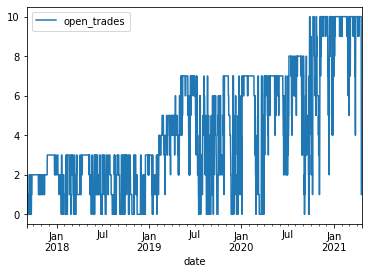

In [163]:
from freqtrade.data.btanalysis import analyze_trade_parallelism

# Analyze the above
parallel_trades = analyze_trade_parallelism(trades, '4h')

parallel_trades.plot()

In [164]:
from freqtrade.plot.plotting import  generate_candlestick_graph
# Limit graph period to keep plotly quick and reactive

# Filter trades to one pair
trades_red = trades.loc[trades['pair'] == pair]
data.set_index('date', drop=False)
data_red = data['2017-01-01':'2021-06-10']
# Generate candlestick graph
graph = generate_candlestick_graph(pair=pair,
                                   data=data_red,
                                   trades=trades_red,
                                   indicators1=['ema_fast', 'ema_slow', 'trail2','greenLine'],
                                   indicators2=['rsi']
                                  )

graph.show(renderer="browser")


f:\projects\freqtrade\freqtrade\plot\plotting.py:180: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [165]:
 trades.loc[trades['pair'] == pair]

,pair,stake_amount,amount,open_date,close_date,open_rate,close_rate,fee_open,fee_close,trade_duration,...,sell_reason,initial_stop_loss_abs,initial_stop_loss_ratio,stop_loss_abs,stop_loss_ratio,min_rate,max_rate,is_open,open_timestamp,close_timestamp
0,BTC/USDT,500,0.11450845,2017-09-06 00:00:00+00:00,2017-09-10 08:00:00+00:00,4366.49,3988.89,0.001,0.001,6240,...,sell_signal,3493.192,-0.2,3493.192,-0.2,4100.00,4788.59,False,1.50465600e+12,1.50503040e+12
3,BTC/USDT,500,0.13262811,2017-09-16 04:00:00+00:00,2017-09-16 12:00:00+00:00,3769.94,3630.06,0.001,0.001,480,...,sell_signal,3015.952,-0.2,3015.952,-0.2,3769.94,3935.93,False,1.50553440e+12,1.50556320e+12
5,BTC/USDT,500,0.13513039,2017-09-17 20:00:00+00:00,2017-09-21 04:00:00+00:00,3700.13,3820.02,0.001,0.001,4800,...,sell_signal,2960.104,-0.2,2960.104,-0.2,3700.13,4123.20,False,1.50567840e+12,1.50596640e+12
8,BTC/USDT,500,0.12771359,2017-09-25 16:00:00+00:00,2017-11-12 20:00:00+00:00,3915.01,6020.07,0.001,0.001,69360,...,sell_signal,3132.008,-0.2,3132.008,-0.2,3915.01,7770.02,False,1.50635520e+12,1.51051680e+12
16,BTC/USDT,500,0.07596464,2017-11-13 16:00:00+00:00,2017-11-13 20:00:00+00:00,6582.01,6337.01,0.001,0.001,240,...,sell_signal,5265.608,-0.2,5265.608,-0.2,6500.00,6599.61,False,1.51058880e+12,1.51060320e+12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
692,BTC/USDT,500,0.02720222,2020-12-12 08:00:00+00:00,2021-01-22 04:00:00+00:00,18380.85,30943.40,0.001,0.001,58800,...,sell_signal,14704.680,-0.2,14704.680,-0.2,18380.85,41950.00,False,1.60776000e+12,1.61128800e+12
732,BTC/USDT,500,0.01498434,2021-01-29 00:00:00+00:00,2021-01-31 20:00:00+00:00,33368.18,32807.29,0.001,0.001,4080,...,sell_signal,26694.544,-0.2,26694.544,-0.2,33077.90,38531.90,False,1.61187840e+12,1.61212320e+12
733,BTC/USDT,500,0.01462701,2021-02-01 12:00:00+00:00,2021-02-28 04:00:00+00:00,34183.33,44632.70,0.001,0.001,38400,...,sell_signal,27346.664,-0.2,27346.664,-0.2,34039.00,58352.80,False,1.61218080e+12,1.61448480e+12
743,BTC/USDT,500,0.01047726,2021-03-01 12:00:00+00:00,2021-03-25 08:00:00+00:00,47722.42,52270.72,0.001,0.001,34320,...,sell_signal,38177.936,-0.2,38177.936,-0.2,47523.59,61844.00,False,1.61460000e+12,1.61665920e+12


In [166]:
trades.columns


Index(['pair', 'stake_amount', 'amount', 'open_date', 'close_date',
       'open_rate', 'close_rate', 'fee_open', 'fee_close', 'trade_duration',
       'profit_ratio', 'profit_abs', 'sell_reason', 'initial_stop_loss_abs',
       'initial_stop_loss_ratio', 'stop_loss_abs', 'stop_loss_ratio',
       'min_rate', 'max_rate', 'is_open', 'open_timestamp', 'close_timestamp'],
      dtype='object')

In [167]:
trades.loc[trades['pair'] == pair,['pair','stake_amount','profit_ratio','profit_abs','stop_loss_abs','stop_loss_ratio','min_rate','max_rate']]

,pair,stake_amount,profit_ratio,profit_abs,stop_loss_abs,stop_loss_ratio,min_rate,max_rate
0,BTC/USDT,500,-0.08830200,-44.19515233,3493.192,-0.2,4100.00,4788.59
3,BTC/USDT,500,-0.03902791,-19.53346804,3015.952,-0.2,3769.94,3935.93
5,BTC/USDT,500,0.03033882,15.18458165,2960.104,-0.2,3700.13,4123.20
8,BTC/USDT,500,0.53461725,267.57592503,3132.008,-0.2,3915.01,7770.02
16,BTC/USDT,500,-0.03914630,-19.59272550,5265.608,-0.2,6500.00,6599.61
...,...,...,...,...,...,...,...,...
692,BTC/USDT,500,0.68009505,340.38751976,14704.680,-0.2,18380.85,41950.00
732,BTC/USDT,500,-0.01877355,-9.39616220,26694.544,-0.2,33077.90,38531.90
733,BTC/USDT,500,0.30307737,151.69019662,27346.664,-0.2,34039.00,58352.80
743,BTC/USDT,500,0.09311898,46.60606753,38177.936,-0.2,47523.59,61844.00


In [168]:
trades['maximum_lost'] = trades.groupby("pair")['profit_ratio'].agg('min')
# trades.groupby("pair")["sell_reason"].value_counts()
trades.loc[:,['pair','stake_amount','profit_ratio','profit_abs','stop_loss_abs','stop_loss_ratio','min_rate','max_rate','maximum_lost']]

,pair,stake_amount,profit_ratio,profit_abs,stop_loss_abs,stop_loss_ratio,min_rate,max_rate,maximum_lost
0,BTC/USDT,500,-0.08830200,-44.19515233,3493.1920000,-0.2,4100.000000,4788.590000,NaN
1,ETH/USDT,500,-0.09853335,-49.31594236,260.4400000,-0.2,310.460000,342.500000,NaN
2,ETH/USDT,500,-0.06524403,-32.65463813,250.9600000,-0.2,297.660000,313.700000,NaN
3,BTC/USDT,500,-0.03902791,-19.53346804,3015.9520000,-0.2,3769.940000,3935.930000,NaN
4,ETH/USDT,500,-0.05334654,-26.69994306,210.8400000,-0.2,258.190000,268.720000,NaN
...,...,...,...,...,...,...,...,...,...
762,ETH/USDT,500,0.00074236,0.37155135,1346.0320000,-0.2,1682.540000,1732.670000,NaN
763,REEF/USDT,500,-0.02836295,-14.19565802,0.0297376,-0.2,0.037172,0.045687,NaN
764,ETH/USDT,500,0.36339858,181.88099380,1357.2080000,-0.2,1696.510000,2548.290000,NaN
765,LINK/USDT,500,0.31119207,155.75162936,24.3038400,-0.2,30.293300,44.330000,NaN


In [172]:

summaryTrade = trades.groupby("pair").agg(
    maximum_lost = pd.NamedAgg(column='profit_ratio' , aggfunc=min),
    #trades_count = pd.NamedAgg(column='profit_ratio', aggfunc=count),
    trades_count = pd.NamedAgg(column='profit_ratio', aggfunc=lambda x:x.count())
    
)
summaryTrade['win_count'] = trades.loc[(trades['profit_ratio'] > 0 )].groupby("pair")['profit_ratio'].count()
summaryTrade['loss_count'] = trades.loc[(trades['profit_ratio'] < 0 )].groupby("pair")['profit_ratio'].count()
summaryTrade['win_ration'] = trades.loc[(trades['profit_ratio'] > 0 )].groupby("pair")['profit_ratio'].count()/summaryTrade['trades_count']
summaryTrade['loss_ration'] = trades.loc[(trades['profit_ratio'] < 0 )].groupby("pair")['profit_ratio'].count()/summaryTrade['trades_count']

summaryTrade['win_avg'] = trades.loc[(trades['profit_ratio'] > 0 )].groupby("pair")['profit_ratio'].mean()
summaryTrade['loss_avg'] = trades.loc[(trades['profit_ratio'] < 0 )].groupby("pair")['profit_ratio'].mean()
summaryTrade['riskreward'] = abs(summaryTrade['win_avg']/summaryTrade['loss_avg']) 

summaryTrade['std_win'] =  trades.loc[(trades['profit_ratio'] > 0 )].groupby("pair")['profit_ratio'].apply(lambda x: statistics.stdev(x))
summaryTrade['std_loss'] = trades.loc[(trades['profit_ratio'] < 0 )].groupby("pair")['profit_ratio'].apply(lambda x: statistics.stdev(x))
summaryTrade['std_all'] =  trades.groupby("pair")['profit_ratio'].apply(lambda x: statistics.stdev(x))
summaryTrade['std_riskreward'] = summaryTrade['std_win']/summaryTrade['std_loss']

summaryTrade

,maximum_lost,trades_count,win_count,loss_count,win_ration,loss_ration,win_avg,loss_avg,riskreward,std_win,std_loss,std_all,std_riskreward
pair,,,,,,,,,,,,,
BNB/USDT,-0.20159840,113.0,22.0,91,0.19469027,0.80530973,1.18276315,-0.03565420,33.17317474,2.89492267,0.03993923,1.34442307,72.48317888
BTC/USDT,-0.12399018,130.0,35.0,95,0.26923077,0.73076923,0.18103292,-0.02416450,7.49168842,0.28139954,0.02153818,0.17192168,13.06515108
BTT/USDT,-0.14521810,85.0,19.0,66,0.22352941,0.77647059,0.33470329,-0.03155304,10.60764116,0.66582307,0.03070855,0.34537896,21.68201274
DOT/USDT,-0.20159840,14.0,6.0,8,0.42857143,0.57142857,0.85031720,-0.04655336,18.26543174,1.99084744,0.06459902,1.31863689,30.81854101
ETH/USDT,-0.18405630,130.0,31.0,99,0.23846154,0.76153846,0.28938241,-0.03333156,8.68193291,0.50242376,0.03215501,0.28026596,15.62505295
IOST/USDT,-0.20159840,83.0,24.0,59,0.28915663,0.71084337,0.16775433,-0.04193319,4.00051406,0.31433360,0.04400140,0.19552754,7.14371800
KNC/USDT,-0.20159840,27.0,8.0,19,0.29629630,0.70370370,0.27529946,-0.04682274,5.87961069,0.37278130,0.05024148,0.24825101,7.41979106
LINK/USDT,-0.12495907,64.0,18.0,46,0.28125000,0.71875000,0.52186966,-0.03380672,15.43686307,0.68009269,0.03152651,0.43465845,21.57209207
NEAR/USDT,-0.07718931,8.0,6.0,2,0.75000000,0.25000000,0.51772922,-0.05845791,8.85644421,0.78451045,0.02649020,0.71473995,29.61512002


In [ ]:
statistics.stdev(trades.loc[(trades['profit_ratio'] < 0 ),'profit_ratio'])